## Dataset Description

The data files **train.csv** and **test.csv** contain gray-scale images of hand-drawn digits, **from zero through nine**.

Each image is **28 pixels in height and 28 pixels in width**, for a total of 784 pixels in total. Each pixel has a single **pixel-value** associated with it, **indicating the lightness or darkness** of that pixel, with higher numbers meaning darker. This pixel-value is an **integer between 0 and 255, inclusive.**

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then **pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).**

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

```
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
```

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Source: https://www.kaggle.com/competitions/digit-recognizer/data

---


In [1]:
# Use GPU Accelerator -> This notebooks has been created using Kaggle's GPU T4 x 2

## Libraries & Imports

In [2]:
# For a visual representation of the cnn architecture
!pip install torchviz --quiet

In [3]:
# Libraries
from torch.utils.data import DataLoader, Dataset, random_split
from IPython.display import display_html
from torchviz import make_dot

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import seaborn as sns
import pandas as pd
import torchvision
import numpy as np
import random
import torch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
class CustomMNISTDataset(Dataset): # torch.utils.data.Dataset
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform # A composition of image transformations.
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame) # Total number of samples in dataset.

    def __getitem__(self, index): # To retrieve a single sample.
        item = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.uint8) # Using uint8 cause 2**8 = 256 and each value in the dataset varies from 0 to 255.
            label = None # No label in test data.
        else:
            image = item[1:].values.reshape(28, 28).astype(np.uint8) # First element is the label (avoid).
            label = item.iloc[0]

        image = transforms.ToPILImage()(image) # Converting NumPy array into pillow image object to work with PyTorch's transforms.

        if self.transform is not None:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            return image, label   

In [6]:
# Using a Composition to chain together multiple transformations:
transform = transforms.Compose([
    transforms.RandomRotation(15), # Data Augmentation by random rotations of +/- 15 degrees.
    transforms.ToTensor(), # To work with Tensors. This adds rescaling [0.0, 1.0] and rearranges image dimensions to [channels, height, width].
    transforms.Normalize((0.5,), (0.5,)) # Normalization with mean of 0.5 and standar deviation of 0.5.
])

# Other ideas of transformations:
# RandomAffine()
# RandomResizedCrop(9)
# Pad()

In [7]:
full_train_data = CustomMNISTDataset(csv_file = '/kaggle/input/digit-recognizer/train.csv',
                                transform = transform,
                                is_test = False)

train_ratio = 0.8
val_ratio = 1 - train_ratio

train_size = int(train_ratio * len(full_train_data))
val_size = len(full_train_data) - train_size

train_data, val_data = random_split(full_train_data, [train_size, val_size])

test_data = CustomMNISTDataset(csv_file = '/kaggle/input/digit-recognizer/test.csv',
                               transform = transform,
                               is_test = True)

print(f'Train Size: {len(train_data):,}\nValidation Size: {len(val_data):,}\nTest Size: {len(test_data):,}')

Train Size: 33,600
Validation Size: 8,400
Test Size: 28,000


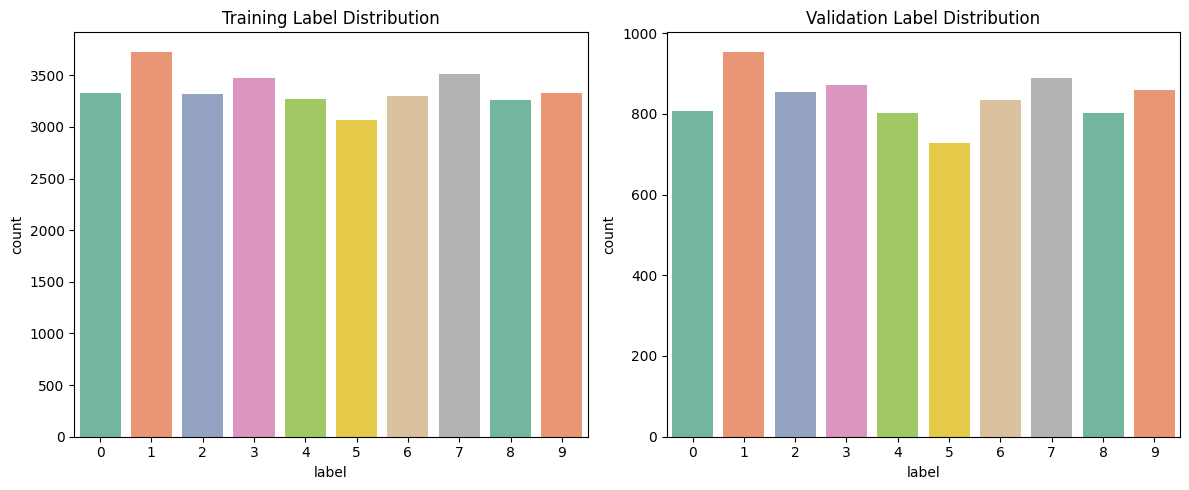

In [8]:
# Labels Frequency:
train_label_observations = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
val_label_observations = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in train_data:
    train_label_observations[data[1]] += 1

for data in val_data:
    val_label_observations[data[1]] += 1

# Long format for Seaborn:
train_df = pd.DataFrame({
    'label': list(train_label_observations.keys()),
    'count': list(train_label_observations.values()),
    'dataset': 'train'
})

val_df = pd.DataFrame({
    'label': list(val_label_observations.keys()),
    'count': list(val_label_observations.values()),
    'dataset': 'val'
})

palette = sns.color_palette("Set2", 10)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

sns.barplot(data=train_df, x='label', y='count', palette=palette, ax=axes[0])
axes[0].set_title("Training Label Distribution")

sns.barplot(data=val_df, x='label', y='count', palette=palette, ax=axes[1])
axes[1].set_title("Validation Label Distribution")

plt.tight_layout()
plt.show()

In [9]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size = batch_size,
                                           shuffle = True, # Shuffling helps prevent the model from learning any spurious correlations based on the order of samples in the dataset.
                                           num_workers = 2)

val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 2)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 2)

# num_workers = This can significantly speed up data loading, especially when having complex data preprocessing or a large dataset, 
#               as it prevents the CPU from becoming a bottleneck (waiting for data) during GPU computations.

Input Size: torch.Size([64, 1, 28, 28])


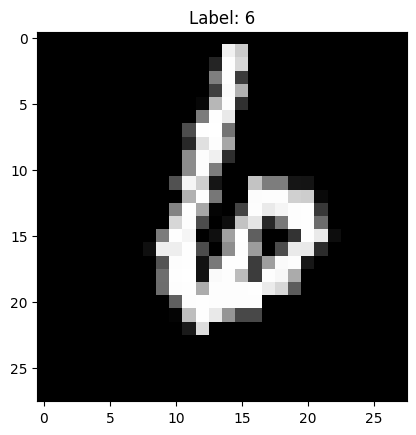

In [10]:
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print(f'Input Size: {example_data.size()}')

    example_image_numpy = example_image.permute(1, 2, 0).numpy()

    plt.imshow(example_image_numpy, cmap='gray')
    plt.title(f'Label: {example_labels[0]}')
    plt.show()

    break

In [12]:
# Neural Network Architecture Definition:

class SimpleCNN(nn.Module): #PyTorch
    def __init__(self):
        super(SimpleCNN, self).__init__() # Calls the constructor of the parent class.
        
        self.conv1 = nn.Conv2d(in_channels = 1, # Grayscale
                               out_channels = 32,
                               kernel_size = 3,
                               stride = 1, # The filter moves one pixel at a time.
                               padding = 1) # Ensures that the output feature map has the same spatial dimensions (height and width) as the input.
        
        self.relu1 = nn.ReLU() # ReLU introduces non-linearity into the model, allowing it to learn more complex patterns.
        
        self.pool1 = nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)
        
        self.conv2 = nn.Conv2d(in_channels = 32,
                               out_channels = 64,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1)

        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(in_channels = 64,
                               out_channels = 128,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1)

        self.relu3 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size = 2,
                                 stride = 2)

        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x): # How the input x flows through the layers.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool2(x)

        x_size = x.size(1) * x.size(2) * x.size(3) # Necessary for flattening the tensor before feeding it into the fully connected layers.

        x = x.view(-1, x_size) # Flattening (Tensor reshape).
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [13]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr = 0.001,
                      momentum = 0.9) 

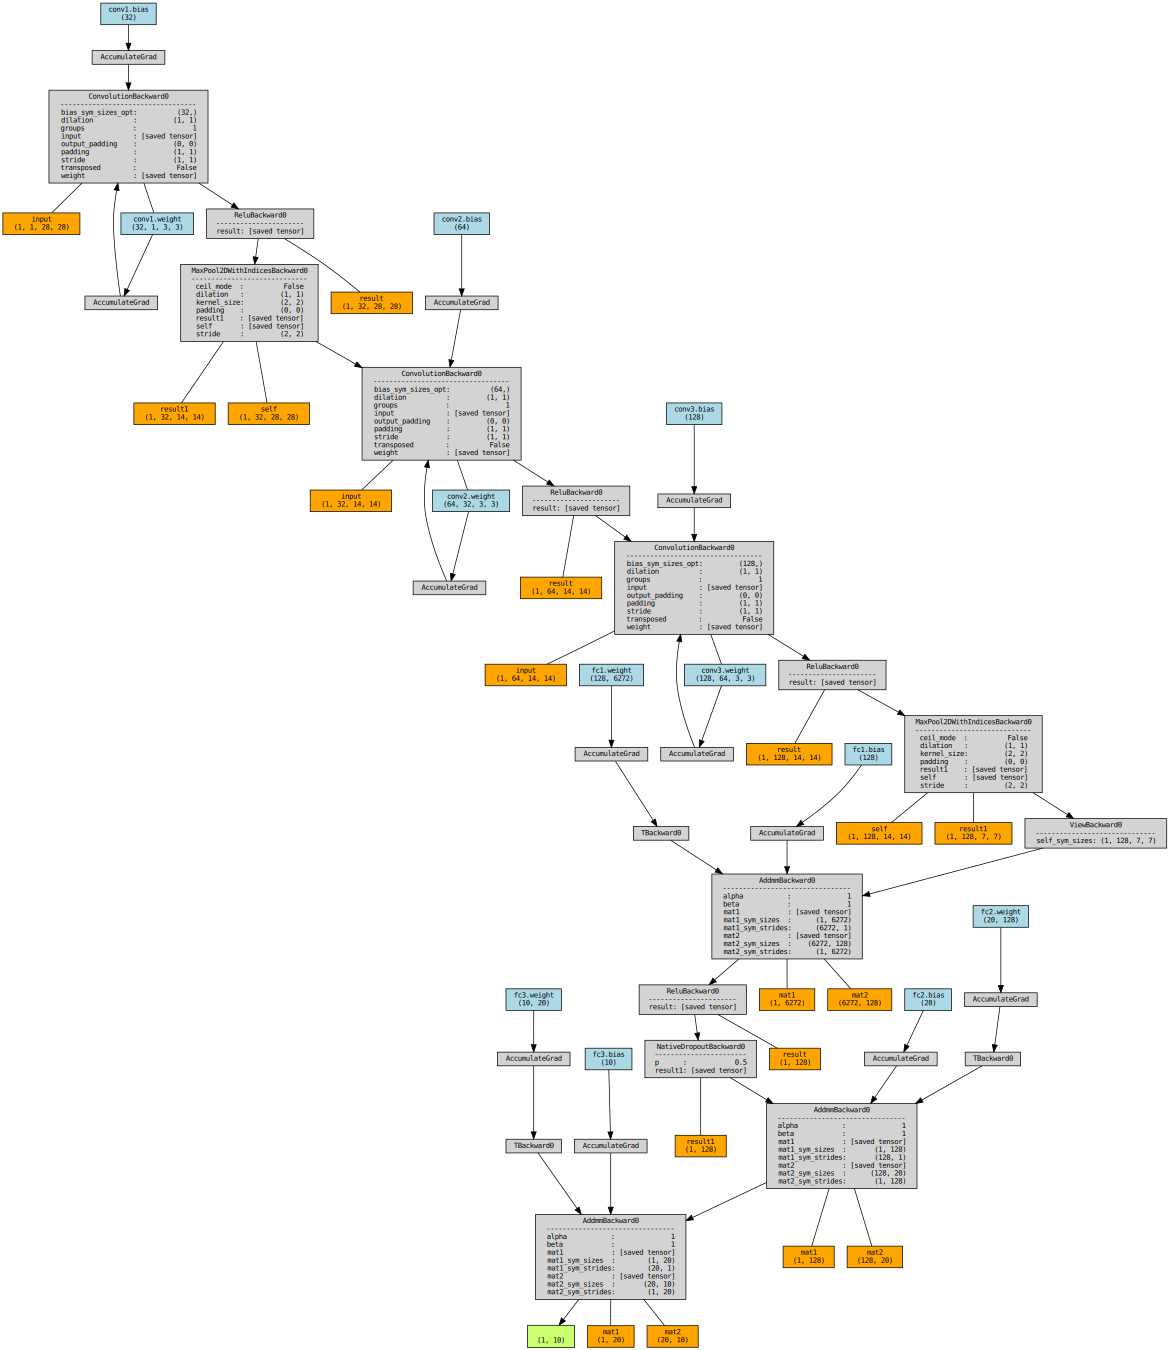

In [14]:
# Visual representation of CNN's Architecture:

dummy_input = torch.randn(1, 1, 28, 28).to(device) # Dummy input for MNIST: (batch_size, channels, height, width)
output = model(dummy_input) # Forward pass to create the computational graph.
dot = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot
# Render to a file (e.g., PNG, SVG, PDF)
#dot.render("simple_cnn_graph", format="png", cleanup=True) # cleanup=True removes intermediate .dot file

In [ ]:
num_epochs = 300

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] | '
          f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | '
          f'Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%')

print('Training Finished')

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch [1/300] | Train Loss: 2.2169 | Train Acc: 23.29% | Val Loss: 1.7063 | Val Acc: 54.23%
Epoch [2/300] | Train Loss: 0.8618 | Train Acc: 72.33% | Val Loss: 0.3997 | Val Acc: 88.17%
Epoch [3/300] | Train Loss: 0.4177 | Train Acc: 87.04% | Val Loss: 0.2536 | Val Acc: 92.05%
Epoch [4/300] | Train Loss: 0.2877 | Train Acc: 91.44% | Val Loss: 0.1830 | Val Acc: 94.25%
Epoch [5/300] | Train Loss: 0.2229 | Train Acc: 93.20% | Val Loss: 0.1432 | Val Acc: 95.54%
Epoch [6/300] | Train Loss: 0.1878 | Train Acc: 94.37% | Val Loss: 0.1228 | Val Acc: 95.94%
Epoch [7/300] | Train Loss: 0.1614 | Train Acc: 95.15% | Val Loss: 0.1054 | Val Acc: 96.52%
Epoch [8/300] | Train Loss: 0.1451 | Train Acc: 95.68% | Val Loss: 0.0985 | Val Acc: 96.73%
Epoch [9/300] | Train Loss: 0.1338 | Train Acc: 95.98% | Val Loss: 0.0879 | Val Acc: 97.27%
Epoch [10/300] | Train Loss: 0.1263 | Train Acc: 96.19% | Val Loss: 0.0865 | Val Acc: 97.29%
Epoch [11/300] | Train Loss: 0.1158 | Train Acc: 96.56% | Val Loss: 0.0901 | Va

In [22]:
model.eval()
predictions = []

# Inference Loop:
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().tolist())

In [23]:
submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

submission.to_csv('submission3.csv', index = False)

Input Size: torch.Size([64, 1, 28, 28])


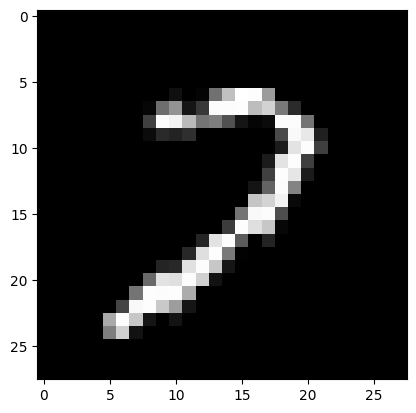

Estimated Label = 7


In [24]:
# Visual Testing:

for example_data in test_loader:
    int_rnd = random.randint(0, 64 - 1)
    example_image = example_data[int_rnd]
    print(f'Input Size: {example_data.size()}')

    example_image_numpy = example_image.permute(1, 2, 0).numpy()

    plt.imshow(example_image_numpy, cmap='gray')
    plt.show()

    break

print(f"Estimated Label = {submission.iloc[int_rnd]['Label']}")

## Saving Model

In [26]:
def saveModel(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def loadModel(path):
    loaded_model = SimpleCNN()
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.to(device)
    print("Model loaded successfully!")

In [27]:
saveModel(model, 'simple_cnn_model2.pth')

Model saved to simple_cnn_model2.pth
